#### Import statements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

#### Import data and rename the columns

In [2]:
df = pd.read_csv("cardio_data.csv", index_col="id")

# Improve column names for readability
df.rename(str.capitalize, axis='columns', inplace=True)
df.rename(columns={'Ap_hi': 'BP_hi', 'Ap_lo': 'BP_lo', 'Gluc': 'Glucose', 'Alco': 'Alcohol'},
          inplace=True)

#### Add Features: 'BMI' (float) and 'Overweight' (0/1)

In [3]:
df["BMI"] = df["Weight"] / (df["Height"] / 100) ** 2  # Calculate bmi (kg/m^2)
df["Overweight"] = df["BMI"].apply(lambda x: 0 if x <= 25 else 1)
# Two more ways of doing the same:
# df["Overweight"] = pd.factorize(df["BMI"] > 25)[0]
# df['Overweight'] = pd.factorize(pd.cut(df["BMI"],
#                                 bins=pd.IntervalIndex.from_tuples([(0, 25), (25, 100)])))

# New columns are added at the end of dataframe. For consistency, make the target column
# ('Cardio') the last column and reposition new columns to follow the "Height" and "Weight" Features.
df = df[['Age', 'Gender', 'Height', 'Weight', 'BMI', 'Overweight', 'BP_hi', 'BP_lo',
           'Cholesterol', 'Glucose', 'Smoke', 'Alcohol', 'Active', 'Cardio']]

#### Cleanup the data
- Change "Age" from days to years.
- Make "Gender" values start from 0.
- Normalize data by making 0 always good and 1 always bad.
- Remove wrong data or outliers.

In [4]:
def cleanup(data):
    """
    - Change "Age" from days to years.
    - Make "Gender" values start from 0.
    - Normalize data by making 0 always good and 1 always bad.
    - Remove wrong data or outliers.

    :parameter data: pandas dataframe containing all of the data
    :return: cleaned dataframe
    """

    data["Age"] = data["Age"] / 365
    data["Gender"] = data["Gender"] - 1

    # If the value of 'Cholesterol' or 'Glucose' is 1, make the value 0.
    # If the value is more than 1, make the value 1.
    for feat in ["Glucose", "Cholesterol"]:
        data[feat] = data[feat].apply(lambda x: 0 if x == 1 else 1)

    # Clean up data
    data = data[(data.BP_lo < data.BP_hi) &  # Diastolic pressure MUST be less than the systolic
                (data.BP_lo.between(50, 120)) &  # Diastolic blood pressure should be positive
                (data.BP_hi.between(100, 200)) &  # Reasonable values for systolic blood pressure
                (data.Gender < 2) &  # Gender can only be in [0, 1] = [Female, Male]
                (data.Height >= data.Height.quantile(0.0025)) &  # keep heights >= 0.25th percentile (h>=140cm)
                (data.Height <= data.Height.quantile(0.9999)) &  # keep heights <= 99.75th percentile (h<=198cm)
                (data.Weight >= data.Weight.quantile(0.0025)) &  # keep weights >= 0.25th percentile (w>=42kg=92.4lbs)
                (data.Weight <= data.Weight.quantile(0.9975)) &  # keep weights <= 99.75th percentile (w<=133kg=292.6lbs)
                (data.BMI >= data.BMI.quantile(0.001)) &  # keep bmi >= 0.1th percentile (bmi>=16.1)
                (data.BMI <= data.BMI.quantile(0.999))]  # keep bmi <= 99.9th percentile (bmi<=59.2)

    return data

In [5]:
data_clean = cleanup(df)  # get the cleaned data

#### Draw plots to describe the data

In [7]:
def draw_cat_plot(dframe: pd.DataFrame, id_var: str, cat_feats: list, *, output_filename: str = None):
    """
    Draw plot showing value counts of categorical features.

    :parameter dframe: pandas dataframe containing the feature `id_var` and all of the features in `cat_feats`.
                       Note: this implementation does not check that all of the relevant features are in `dframe`.
    :parameter id_var: Feature name (string) with respect to which panels of the categorical plot
                       are made. For instance, for a binary feature, the plot will
                       have two panels showing the respective counts of categorical features.
    :parameter cat_feats: list of strings of categorical features to plot.
    :parameter output_filename: if the plot is to be saved, this is its name.
                                (default=None, i.e., plot is not saved)
    :return: Seaborn figure object.
    """

    # Create DataFrame for catplot using `pd.melt` with just the values from categorical features
    df_cat = pd.melt(dframe, id_vars=id_var, value_vars=cat_feats)

    # Draw the catplot
    fig = sns.catplot(x="variable", hue="value", col=id_var, data=df_cat, kind="count")
    fig.set_xlabels('')
    fig.set_xticklabels(rotation=90)
    fig.savefig(output_filename) if output_filename is not None else True

    return fig

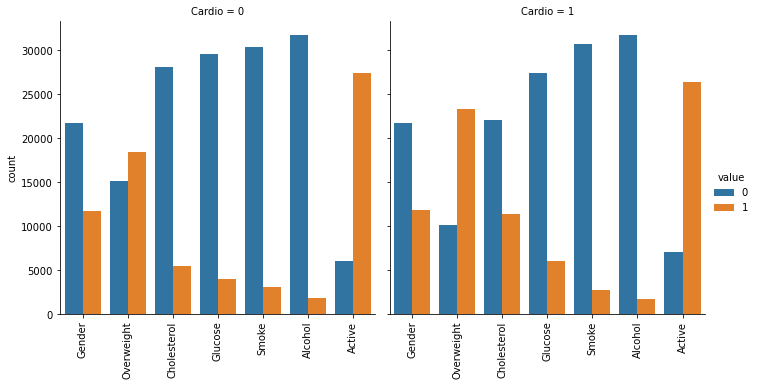

In [8]:
# Categorical features
cat_feats = ["Gender", "Overweight", "Cholesterol", "Glucose", "Smoke", "Alcohol", "Active"]

# Draw plot to describe the categorical data.
fig_cat = draw_cat_plot(data_clean, "Cardio", cat_feats, output_filename='catfeats_plot.png')

#### Plot some numerical features

In [ ]:
# Numerical features
num_feats = ["Age", "Height", "Weight", "BMI", "BP_hi", "BP_lo"]

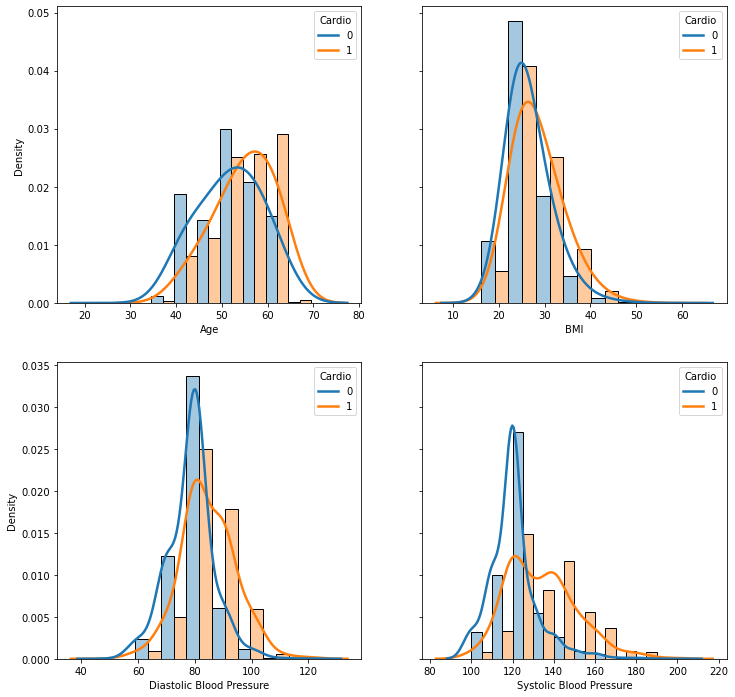

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(12, 12), sharey='row')

sns.histplot(data=data_clean, x="Age", hue="Cardio", binwidth=5, multiple='dodge', stat='density', alpha=0.4, ax=ax1[0])
sns.kdeplot(data=data_clean, x="Age", hue="Cardio", bw_adjust=5, fill=False, linewidth=2.5, ax=ax1[0])
ax1[0].set_xlabel('Age')

sns.histplot(data=data_clean, x="BMI", hue="Cardio", binwidth=6, multiple='dodge', stat='density', alpha=0.4, ax=ax1[1])
sns.kdeplot(data=data_clean, x="BMI", hue="Cardio", bw_adjust=5, fill=False, linewidth=2.5, ax=ax1[1])
ax1[1].set_xlabel('BMI')

sns.histplot(data=data_clean, x="BP_lo", hue="Cardio", binwidth=9, multiple='dodge', stat='density', alpha=0.4, ax=ax2[0])
sns.kdeplot(data=data_clean, x="BP_lo", hue="Cardio", bw_adjust=4, fill=False, linewidth=2.5, ax=ax2[0])
ax2[0].set_xlabel('Diastolic Blood Pressure')

sns.histplot(data=data_clean, x="BP_hi", hue="Cardio", binwidth=10, multiple='dodge', stat='density', alpha=0.4, ax=ax2[1])
sns.kdeplot(data=data_clean, x="BP_hi", hue="Cardio", bw_adjust=2.75, fill=False, linewidth=2.5, ax=ax2[1])
ax2[1].set_xlabel('Systolic Blood Pressure')

fig.savefig('numfeats_plot.png')

#### Find correlation between features

In [11]:
def draw_corr_matrix(dfr: pd.DataFrame):
    """
    - Draw correlation matrix as a heatmap.
    - Draw correlation for target feature and mutual information in a bar plot.
    Note: Assuming the target feature is in the last column of df.

    :parameter dfr: pandas dataframe with all of the relevant features as columns.
    :return: fig: matplotlib figure object;
             corr: correlation matrix for all features;
             scores: pandas dataframe with the correlation and mutual information scores
                     for the target feature.
    """

    target = dfr.columns[-1]

    corr = dfr.corr()  # Calculate the correlation matrix
    target_corr = corr.loc[target, corr.columns.delete(-1)]  # Correlation for the target
    mi = mutual_info_classif(dfr.iloc[:, :-1], dfr[target])  # Calculate MI score
    scores = target_corr.to_frame()
    scores.rename(columns={target: "Corr"}, inplace=True)
    scores["MI"] = mi
    scores_melted = pd.melt(scores, ignore_index=False)

    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True  # Generate a mask for the upper triangle

    fig, ax = plt.subplots(2, 1, figsize=(8, 16), dpi=100)
    sns.heatmap(corr, mask=mask, square=True, ax=ax[0], cmap='Spectral_r',
                annot=True, fmt='.2f', annot_kws={'fontsize': 8})
    ax[0].set_title("Feature Correlation", fontdict={"fontsize": 14})

    # Plot the target correlation and mutual information scores on the same graph.
    sns.barplot(x="value", y=scores_melted.index, hue="variable",
                data=scores_melted, ax=ax[1], palette='crest')
    ax[1].set_title(f"Target ({target}) Correlation and Mutual Information",
                    fontdict={"fontsize": 14})
    ax[1].set_xlabel(None)
    ax[1].legend(title=None)
    ax[1].grid(axis='x')

    fig.savefig('Corr_matrix_Target.png')

    return fig, corr, scores

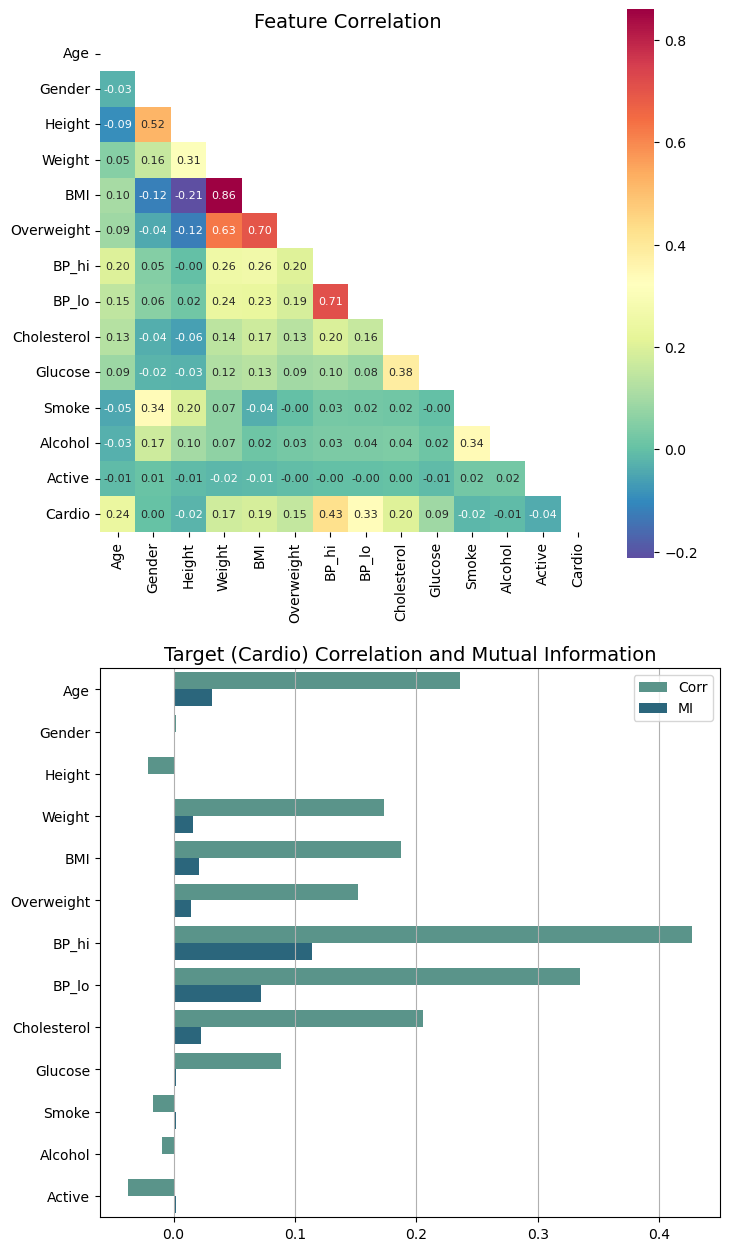

In [12]:
fig_corr, corr_matrix, target_scores = draw_corr_matrix(data_clean)

#### Prepare data for kNN model

In [18]:
X = data_clean.copy()
y = X.pop("Cardio")  # target variable

# Split data (with all of the features) into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#### K-nearest neighbors model

In [103]:
def get_cv_score(X: pd.DataFrame, y: pd.Series, Classifier, *, options: dict = {}, cv: int = 10, scoring='accuracy'):
    """
    Get cross-validation score.

    :parameter X: pandas dataframe with explanatory data.
    :parameter y: pandas series with target data.
    :parameter Classifier: name of classifier.
    :parameter options: options to pass to Classifier (default=None).
    :parameter cv: number of cross-validation folds (default=10).
    :parameter scoring: metric to evaluate for assessing model fit (default='accuracy').
    :return: Mean cross-validation score.
    """

    scores = cross_val_score(Classifier(**options), X, y, cv=cv, scoring=scoring)
    return scores.mean()


def kNN_model(X_train: pd.DataFrame, X_test: pd.DataFrame, y_train: pd.Series, y_test: pd.Series):
    """
    K-nearest neighbors model: find best hyperparameter k and weight method.
    Then fit to (unscaled) data and predict.

    :parameter X_train: Training data.
    :parameter y_train: Target that corresponds to training data.
    :parameter X_test: Test data.
    :parameter y_test: Target that corresponds to test data.
    :return: Model object, model predictions for test dataset and classification report (dict).
    """

    scores_u = []  # uniform weights
    scores_d = []  # weights inversely related to distance
    k_range = range(20, 71)
    for k in k_range:
        for weight in ['uniform', 'distance']:
            score = get_cv_score(X_train, y_train, KNeighborsClassifier,
                                 options={'n_neighbors': k, 'weights': weight})
            scores_u.append(score) if weight == 'uniform' else scores_d.append(score)

    fig, ax = plt.subplots(figsize=(6, 5), dpi=100)
    ax.plot(k_range, scores_u)
    ax.plot(k_range, scores_d)
    ax.set(title='K-Nearest Neighbors: Mean (cv=10) Accuracy Scores\n'
                 'for Different Weight Methods',
           xlabel='$k$ neighbors', ylabel='Accuracy')
    ax.legend(['uniform', 'distance'], loc='lower right')
    fig.savefig('kNN_cv_search.png')

    k_best_u = scores_u.index(np.max(scores_u))
    k_best_d = scores_d.index(np.max(scores_d))
    print(f"Estimator: K-nearest neighbors:\n"
          f"Optimal k={k_best_u + k_range[0]} with an accuracy of {scores_u[k_best_u]} with "
          "uniform weight method.\n"
          f"Optimal k={k_best_d + k_range[0]} with an accuracy of {scores_d[k_best_d]} with "
          "distance weight method.")

    optimal_hyperparams = {'k': k_best_u + 1 if k_best_u >= k_best_d else k_best_d + 1,
                           'weights': 'uniform' if k_best_u >= k_best_d else 'distance'}

    model = KNeighborsClassifier(n_neighbors=optimal_hyperparams['k'],
                                 weights=optimal_hyperparams['weights'])
    model.fit(X_train, y_train)  # Train the model
    y_pred = model.predict(X_test)  # Predict classes in test set
    print(classification_report(y_test, y_pred))

    return model, y_pred, classification_report(y_test, y_pred, output_dict=True)

Estimator: K-nearest neighbors:
Optimal k=63 with an accuracy of 0.7195388590737427 with uniform weight method.
Optimal k=69 with an accuracy of 0.7179288411846552 with distance weight method.
              precision    recall  f1-score   support

           0       0.70      0.75      0.72      8402
           1       0.73      0.67      0.70      8368

    accuracy                           0.71     16770
   macro avg       0.71      0.71      0.71     16770
weighted avg       0.71      0.71      0.71     16770



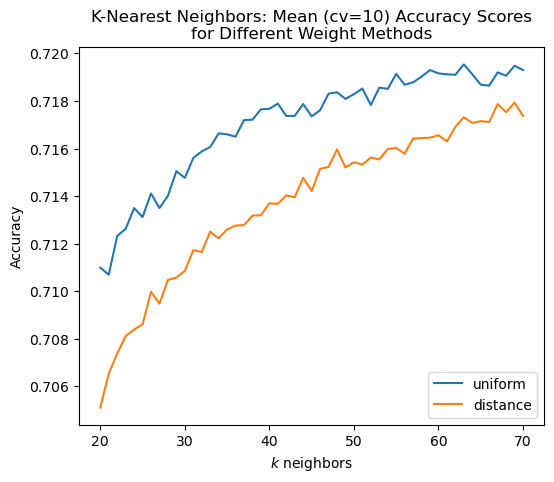

In [22]:
kNN_model, kNN_pred, kNN_report = kNN_model(X_train, X_test, y_train, y_test)

Estimator: K-nearest neighbors:
Optimal k=66 with an accuracy of 0.7227787716159809 with uniform weight method.
Optimal k=70 with an accuracy of 0.7194195984893659 with distance weight method.
              precision    recall  f1-score   support

           0       0.69      0.75      0.72      8402
           1       0.73      0.67      0.70      8368

    accuracy                           0.71     16770
   macro avg       0.71      0.71      0.71     16770
weighted avg       0.71      0.71      0.71     16770



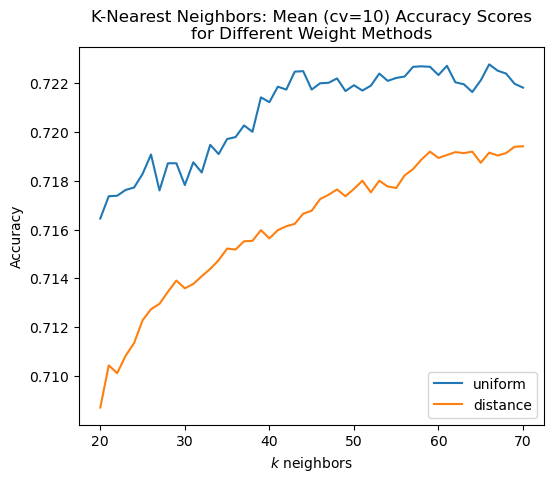

In [104]:
feats = ['Age', 'BMI', 'BP_hi', 'BP_lo', 'Cholesterol', 'Glucose', 'Active']
kNN_model2, kNN_pred2, kNN_report2 = kNN_model(X_train[feats], X_test[feats], y_train, y_test)